In [1]:
import os
import skimage.io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Extracting the frames

In [2]:
import cv2 as cv

cap = cv.VideoCapture('../data/robot_parcours_1.avi')
fps = cap.get(cv.CAP_PROP_FPS) # store fps for the video that we have to make
frames = [] # creating a list for all consecutive frames

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    frames.append(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

The first frame is shown below in grayscale.

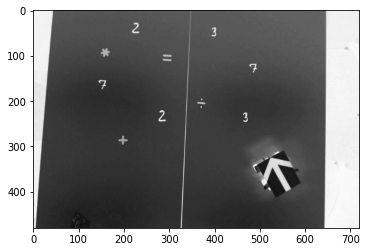

In [3]:
first_frame = frames[0]
(im_h, im_w) = first_frame.shape[:2]

first_frame_gray = 255-cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
plt.imshow(first_frame_gray, cmap='gray')

from PIL import Image
im = Image.fromarray(first_frame_gray)
im.save("first_frame.png")

We process it by binarization.

In [4]:
def binarize(image, treshold):
    if image.ndim == 2:
        mask_white = image[:,:] > treshold
    elif image.ndim == 3:
        mask_white = image[:,:,0] > treshold
    image_binarized = np.zeros((image.shape[0], image.shape[1])).astype(np.uint8)
    image_binarized[mask_white] = 255
    if image.ndim == 2:
        return image_binarized        
    elif image.ndim == 3:
        return image_binarized.reshape(image_binarized.shape[0], image_binarized.shape[1], -1)

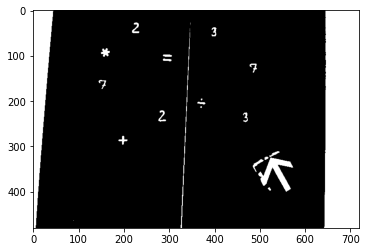

In [5]:
image_binarized = binarize(first_frame_gray, 140)
plt.imshow(image_binarized, cmap='gray')

### 0.0 Tracing the arrow

We would like to know the path of the arrow throughout the video. Since we know that the arrow is the only red object in the image, we can use our knowledge from the second part in lab 1 to keep track of it.

We first normalize the intensity of the first frame

In [6]:
def normalize_intensity(image, linear=True):
    """
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    image = image.astype('float')    
    for i in range(image.shape[2]):
        #min_intensity = np.amin(image[:,:,:])
        #max_intensity = np.amax(image[:,:,:])
        min_intensity = np.percentile(image[:,:,i],5)
        max_intensity = np.percentile(image[:,:,i],50)
        diff = max_intensity - min_intensity
        avg = np.mean(image[:,:,i])
        if min_intensity != max_intensity:
            if linear: 
                factor = 255.0 / diff
                image[:,:,i] = (image[:,:,i] - min_intensity) * factor
            else: 
                image[:,:,i] = 255.0 / (1.0 + np.exp((avg - image[:,:,i]) / diff))
    image = np.clip(image, 0.0, 255.0)
                
    return image.astype('uint8')

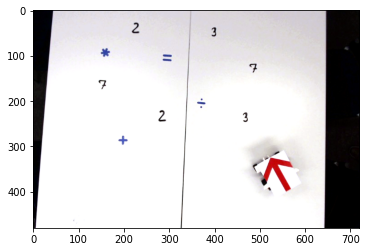

In [7]:
first_frame_normalized = normalize_intensity(first_frame, linear=True)
plt.imshow(first_frame_normalized)

We can now apply a red mask on this normalized first frame.

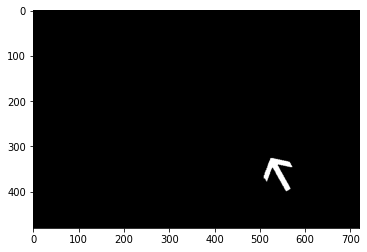

In [8]:
mask_arrow = np.logical_and.reduce((first_frame_normalized[:,:,0]>120, 
                                         first_frame_normalized[:,:,1]<90,
                                         first_frame_normalized[:,:,2]<180))

image_arrow = np.zeros((im_h, im_w))
image_arrow[mask_arrow] = 255
plt.imshow(image_arrow, cmap='gray')

As indicated in this plot, we have found mask boundaries to identify the arrow in the image. It would thus be a good strategy to normalize each frame, then to apply the mask to it and then finally to compute the location of the robot based on this result of this mask. For the latter, we could for example consider the mean of the arrow pixels as the location of the robot; the arrow is symmetric so it kind of makes sense.

In [9]:
normalized_frames = [normalize_intensity(frame, linear=True) for frame in frames]

masks_arrow = [np.logical_and.reduce((frame[:,:,0]>120, 
                                      frame[:,:,1]<90,
                                      frame[:,:,2]<180)) for frame in normalized_frames]

arrows_coords = [np.array(np.where(mask_arrow == True)) for mask_arrow in masks_arrow]

arrow_locations = [np.round(np.mean(arrow_coords, axis=1)).astype(int) for arrow_coords in arrows_coords]

In [10]:
import scipy.misc
from skimage.draw import line
image_path = np.zeros((im_h, im_w))
for i in range(len(arrow_locations)-1):
    location_1 = arrow_locations[i]
    location_2 = arrow_locations[i+1]
    rr, cc = line(location_1[0], location_1[1], location_2[0], location_2[1])
    image_path[rr, cc] = 255

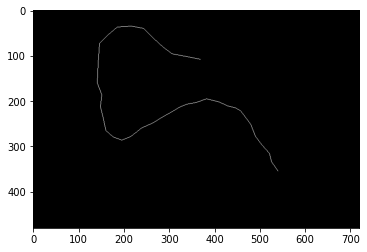

In [11]:
plt.imshow(image_path, cmap='gray')

# 1. Constructing bounding boxes

In the code below, we create bounding boxes for the characters in the first frame. We do this by sliding over the frame with a square window. We start by a window with a side length of 104 pixels and iteratively decrease the window size by 10 pixels until the sliding yields no valid windows. The stride is each time half the window side length.

In a second phase, we start sliding again with the minimal window side length that still yields valid windows; this window side length is obtained through the above-mentioned method. Then we iteratively increase the window side length by 10 (basically in the inverse way as before), do the sliding round each time, until we reach the side length of 104 pixels again. In each sliding round, we discard the windows that overlap with a window from a previous sliding round (so as to deal with overlapping boxes).

This maximum window side of 104 pixels is chosen for multiple reasons, as it is not completely arbitrary. First of all, in this way, we decrease the probability of a single window containing multiple characters. Second of all, we see from the plots above that the characters are all at about 28x28 pixels in size.

Each sliding round, undertaken by the function `detection`, discards all windows that either
- don't satisfy the window dimensions,
- contain a too little amount of white or black pixels,
- or contain white pixels in their edges (so as to not hinder classification in a further stage).

In [12]:
def sliding_window(image, stride, window_size):
    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            yield (j, i, image[i:i+window_size[0], j:j+window_size[1]])

In [13]:
def detection(image, stride, window_side):
    window_no = 1
    windows_to_be_checked = set()
    for (j, i, window) in sliding_window(image, stride, 
                                         window_size=(window_side, window_side)):
        # Check whether window is fully contained within image
        if window.shape[0] != window_side or window.shape[1] != window_side:
            continue
        
        # Check whether window contains too few binary values of one kind
        if np.count_nonzero(window) < 50 or np.count_nonzero(255-window) < 50:
            continue
        
        # Check whether the window edges contain white pixels
        # (in case they do, it's better not to consider this window since it might be too difficult to 
        #  correctly classify the object it contains)
        edges_list = [window[0,:-1], window[:-1,-1], window[-1,::-1], window[-2:0:-1,0]]
        edges_list = np.concatenate(edges_list)
        if 255 in edges_list:
            continue

        window_no += 1
        
        windows_to_be_checked.add((j, i, window_side))
    # print(len(windows_to_be_checked))
    return windows_to_be_checked

In [14]:
def windows_overlap(i_1_min, j_1_min, i_1_max, j_1_max, i_2_min, j_2_min, i_2_max, j_2_max):
    box_1_in_box_2 = ((i_2_min <= i_1_min <= i_2_max) or (i_2_min <= i_1_max <= i_2_max)) and ((j_2_min <= j_1_min <= j_2_max) or (j_2_min <= j_1_max <= j_2_max))
    box_2_in_box_1 = ((i_1_min <= i_2_min <= i_1_max) or (i_1_min <= i_2_max <= i_1_max)) and ((j_1_min <= j_2_min <= j_1_max) or (j_1_min <= j_2_max <= j_1_max))
    return box_1_in_box_2 or box_2_in_box_1

In [15]:
def remove_overlapping_windows_with_same_window_side(windows):
    windows_list = list(windows.copy())
    window_side = windows_list[0][2]
    to_be_removed = []
    for k in range(len(windows_list)):
        j_1 = windows_list[k][0]
        i_1 = windows_list[k][1]
        if (j_1, i_1, window_side) not in to_be_removed:
            for l in range(k+1, len(windows_list)):
                j_2 = windows_list[l][0]
                i_2 = windows_list[l][1]
                if windows_overlap(i_1, j_1, i_1+window_side, j_1+window_side, 
                                   i_2, j_2, i_2+window_side, j_2+window_side):
                    to_be_removed.append((j_2, i_2, window_side))
    to_be_removed = set(to_be_removed)
    return windows.difference(to_be_removed)

For each character, we now obtain a bounding box, specified by a tuple 
$$(\text{horizontal coordinate of upper left corner}, \text{vertical coordinate of upper left corner}, \text{box side length}).$$

In [16]:
symbol_windows = []
for k in range(104, -6, -10):
    if len(detection(image_binarized, stride=int(k/2), window_side=k)) == 0:
        min_window_side = k+10
        break
        
windows_final = detection(image_binarized, stride=int(min_window_side/2), window_side=min_window_side)

for k in range(min_window_side+10, 114, 10):
    windows_temp = detection(image_binarized, stride=int(k/2), window_side=k)
    to_be_removed = set()
    for (j_1, i_1, window_side_1) in windows_final:
        for (j_2, i_2, window_side_2) in windows_temp:
            if (windows_overlap(i_1, j_1, i_1+window_side_1, j_1+window_side_1, 
                                i_2, j_2, i_2+window_side_2, j_2+window_side_2)):
                to_be_removed.add((j_2, i_2, window_side_2))

    windows_temp = windows_temp.difference(to_be_removed)
    if windows_temp != set():
        windows_temp = remove_overlapping_windows_with_same_window_side(windows_temp)
    windows_final = windows_final.union(windows_temp)

windows_final = list(windows_final)
print(windows_final)

[(459, 221, 34), (357, 187, 34), (132, 66, 44), (136, 153, 34), (264, 220, 44), (264, 88, 44), (384, 36, 24), (187, 272, 34), (462, 110, 44), (198, 22, 44)]


The next cell saves an image for every bounding box.

In [17]:
k=1
boxes = []
for (j, i, window_size) in windows_final:
    image = image_binarized[i:i+window_size, j:j+window_size]
    boxes.append(image)
    im = Image.fromarray(image)
    im.save("boxes/box_"+str(k)+".png")
    k += 1

# 2. Processing the obtained boxes

In this step, we process the obtained boxes so that they satisfy the input conditions (size 28x28) of our CNN in a further section. We should take into account that our CNN works optimally if the character is centered within the box, and if it is not too close to the edges of the box.

In [18]:
def square_box(box):
    (height, width) = box.shape
    if height == width:
        return box
    elif height < width:
        diff = width - height
        rows = diff // 2
        result = np.r_[np.zeros((rows, width)), box, np.zeros((rows, width))]
        if diff % 2 != 0:
            result = np.r_[np.zeros((1, width)), result]
    else: 
        diff = height - width
        cols = diff // 2
        result = np.c_[np.zeros((height, cols)), box, np.zeros((height, cols))]
        if diff % 2 != 0:
            result = np.c_[np.zeros((height, 1)), result]
    return result

In [19]:
from skimage.transform import resize

boxes_processed = []
for box in boxes:
    white_pixels = np.nonzero(box)
    top = white_pixels[0].min()
    bottom = white_pixels[0].max()
    left = white_pixels[1].min()
    right = white_pixels[1].max()
    
    center = np.round(np.array([top + (bottom-top)/2, left + (right-left)/2])).astype(np.uint8)
    
    # Minimize the box
    box_processed = box[top:bottom, left:right]
    # Pad 5 rows at the bottom and top
    box_processed = np.r_[np.zeros((3,box_processed.shape[1])), box_processed, np.zeros((3,box_processed.shape[1]))]
    # Pad 5 columns on the left and right
    box_processed = np.c_[np.zeros((box_processed.shape[0], 3)), box_processed, np.zeros((box_processed.shape[0], 3))]
    # Make a square out of the box
    box_processed = square_box(box_processed)
    # Resize to (28, 28)
    box_processed = np.round(resize(box_processed, (28, 28))).astype(np.uint8)
    # Binarize as a last step
    # box_processed = binarize(box_processed, 100)

    boxes_processed.append(box_processed)

The next cell saves an image for every processed bounding box.

In [20]:
k=1
for box in boxes_processed:
    im = Image.fromarray(box)
    im.save("boxes/processed_box_"+str(k)+".png")
    k += 1

# 3 Identifying the characters located within the boxes

We create a dictionary for each box. For each box, we ultimately want its dictionary to contain a 28x28 version of the box, the center location of the character (empirical mean of white pixels within the binarized first frame), its type (digit or operator), and the value of the type (see next section on classificaiton).

In order to determine the type of the character, we once more consider the normalized first frame, and apply a blue and a black mask onto the pixels that define each character. The method used to do this made part of part 2 of lab 1. [NOT VERY ROBUST YET, I JUST CHOSE SOME ARBITRARY VALUES FOR THE BLACK MASK]

In [21]:
boxes_dicts = []

for index in range(len(windows_final)):
    (j, i, window_slide) = windows_final[index]
    
    image_box = boxes_processed[index]
    
    image_filtered = np.zeros((im_h, im_w))
    image_filtered[i:i+window_slide,j:j+window_slide] = image_binarized[i:i+window_slide,j:j+window_slide]
    pixels_locations = np.array(np.nonzero(image_filtered))
    pixels_center = np.round(np.mean(pixels_locations, axis=1)).astype(int)
    
    pixels = first_frame_normalized[pixels_locations[0,:], pixels_locations[1,:]]
    black_pixels = np.logical_and.reduce((pixels[:,0] < 100, 
                                          pixels[:,1] < 100, 
                                          pixels[:,2] < 100))
    nb_pixels = pixels_locations.shape[1]
    nb_black_pixels = np.sum(black_pixels)
    if (nb_black_pixels / nb_pixels < 0.60):
        character_type = 'operator'
    else:
        character_type = 'digit'
    
    boxes_dicts.append(dict(image_box=image_box, center=pixels_center, character_type=character_type))

As a reference, proof-check the values of each dictionary in the image below.

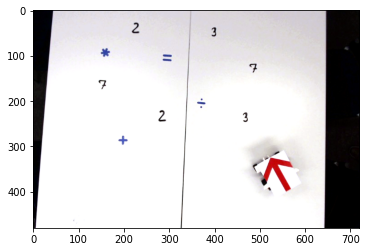

In [22]:
plt.imshow(first_frame_normalized)

# 4. Classification 
### 4.1 Digit classifier: rotated MNIST CNN
#### 4.1.0 Special functions
Some functions for enriching the MNIST datasets.

In [320]:
def pad(image, side):
    diff = int((side - image.shape[0]) / 2)
    return cv.copyMakeBorder(image, diff, diff, diff, diff, cv.BORDER_CONSTANT)

In [321]:
from random import randint

# note: the resulting image completely contains the input image, so the digits cannot stick to the edges,
# is this a problem?
def random_translation(image, side): 
    result = np.zeros((side, side))
    
    trans_range = side-image.shape[0]
    trans_x = randint(0, trans_range-1)
    trans_y = randint(0, trans_range-1)
    
    side = image.shape[0]
    result[trans_y:trans_y+side, trans_x:trans_x+side] = image
    
    return result

In [331]:
from skimage.transform import rescale

def random_scaling(image):
    scale = randint(50, 200)/100
    return rescale(image, scale)

In [332]:
from skimage.transform import rotate

def random_rotation(image): 
    degrees = randint(0, 360-1)
    return rotate(image, degrees)

In [325]:
def random_transformation(image, side, rotate=False, rescale=False, translate=False):
    # side is the output image side length, 
    # but please try side=64 because random_scaling might otherwise act difficult
    assert(image.shape == (28, 28))
    
    if rotate:
        result = random_rotation(image)
    else:
        result = image
        
    if rescale:
        result = random_scaling(result)
        
    if translate:
        return random_translation(result, side)
    else:
        return pad(result, side)

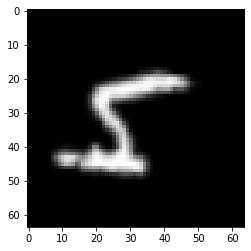

In [350]:
image = x_train[0] # x_train is defined 3 code cells below
plt.imshow(random_transformation(image, 64, True, True, True), cmap='gray')

#### 4.1.1 The classifier
https://keras.io/examples/mnist_cnn/

We now train a CNN that classifies digits, trained on the MNIST dataset, enriched with rotations.

In [23]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [40]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [498]:
x_train = x_train[:2000]
y_train = y_train[:2000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [499]:
from skimage.transform import rotate

degree_diff = 20
assert(360 % degree_diff == 0)
num_rotations = int(360 / degree_diff)

num_trainings = x_train.shape[0]
x_train_rotations = np.zeros((num_rotations*num_trainings, x_train.shape[1], x_train.shape[2]))
x_train_rotations[:x_train.shape[0],:,:] = x_train

num_testings = x_test.shape[0]
x_test_rotations = np.zeros((num_rotations*num_testings, x_test.shape[1], x_test.shape[2]))
x_test_rotations[:x_test.shape[0],:,:] = x_test

for i in range(1, num_rotations):
    degrees = i*degree_diff
    for j in range(num_trainings):
        image = x_train[j]
        x_train_rotations[i*num_trainings+j,:,:] = rotate(image, degrees)
    for j in range(num_testings):
        image = x_test[j]
        x_test_rotations[i*num_testings+j,:,:] = rotate(image, degrees)

In [500]:
y_train_rotations = np.zeros((num_rotations*num_trainings,))
y_test_rotations = np.zeros((num_rotations*num_testings,))

for i in range(0, num_rotations):
    y_train_rotations[i*num_trainings:(i+1)*num_trainings] = y_train
    y_test_rotations[i*num_testings:(i+1)*num_testings] = y_test

In [502]:
batch_size = 20
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train_rotations = x_train_rotations.reshape(x_train_rotations.shape[0], 1, img_rows, img_cols)
    x_test_rotations = x_test_rotations.reshape(x_test_rotations.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_rotations = x_train_rotations.reshape(x_train_rotations.shape[0], img_rows, img_cols, 1)
    x_test_rotations = x_test_rotations.reshape(x_test_rotations.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_rotations = x_train_rotations.astype('float32')
for i in range(x_train_rotations.shape[0]):
    x_train_rotations[i] = binarize(x_train_rotations[i], 0.5)    
x_test_rotations = x_test_rotations.astype('float32')
for i in range(x_test_rotations.shape[0]):
    x_test_rotations[i] = binarize(x_test_rotations[i], 0.5)
x_train_rotations /= 255
x_test_rotations /= 255
print('x_train shape:', x_train_rotations.shape)
print(x_train_rotations.shape[0], 'train samples')
print(x_test_rotations.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_rotations = keras.utils.to_categorical(y_train_rotations, num_classes)
y_test_rotations = keras.utils.to_categorical(y_test_rotations, num_classes)

x_train shape: (36000, 28, 28, 1)
36000 train samples
18000 test samples


In [503]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [504]:
model.fit(x_train_rotations, y_train_rotations,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_rotations, y_test_rotations))

ValueError: Error when checking target: expected dense_12 to have 2 dimensions, but got array with shape (36000, 10, 10)

In [ ]:
model.save_weights('mnist_binarized.h5')

In [473]:
score = model.evaluate(x_test_rotations, y_test_rotations, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6424720804724429
Test accuracy: 0.870555579662323


Nevermind, the CNN fails at correctly classifying the numbers 7 in the sample video. We have to fix this (maybe I should not have binarized the training and test data, I don't know).

array([[5.9116072e-09, 2.2210749e-03, 1.0059301e-08, 4.2639735e-05,
        9.9766821e-01, 1.2585939e-05, 2.9124935e-08, 2.1730528e-05,
        3.2827204e-05, 9.8487851e-07]], dtype=float32)

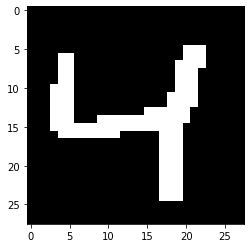

In [496]:
image = x_train_rotations[2]
plt.imshow(image[:,:,0], cmap='gray')


model.predict(image.reshape(1, 28, 28, 1))

### 4.2 Operator classifier

Below is defined a function that classifies an operator to the correct type. If the operator only has 1 contour, we classify it based on its 'higher' frequency DFT coefficients. For a justification of the conditionals involved, check the plot of the DFT coefficients of the three remaining operators, using the original image of operators that is provided to us.

In [24]:
from skimage import measure
from numpy.fft import fft

def classify_operator(image):
    contours = measure.find_contours(image, 0)
    num_contours = len(contours)
    if num_contours == 3:
        return '/'
    elif num_contours == 2:
        return '='
    else: # Only remaining option: num_contours == 1
        contour = max(contours, key=len)
        dft_coeff = fft(contour[:,1]+contour[:,0]*1j)
        if (np.abs(dft_coeff[3]) > np.abs(dft_coeff[5])) and (np.abs(dft_coeff[3]) > np.abs(dft_coeff[7])):
            return '-'
        elif np.abs(dft_coeff[5]) > np.abs(dft_coeff[7]):
            return '+'
        else:
            return '*'

### 4.3 Character classifier

Given a character, we find its type within its dictionary, and then determine its value by one of the two classification methods above. We thus yet need to implement the function `classify_digit`.

In [25]:
for dct in boxes_dicts:
    character_type = dct['character_type']
    image_box = dct['image_box']
    if character_type == 'operator':
        dct['value'] = classify_operator(image_box)
    else:
        dct['value'] = '$'

# 5. Tracing the formula

For each frame, we locate the character with respect to which the arrow is located the closest.

In [86]:
char_sequence = '' # This string will represent the traced formula
char_sequence_list = [] # This list will represent at each index the current state of the formula for the corresponding frame (needed for video)
char_locs = [dct['center'] for dct in boxes_dicts]
char_vals = [dct['value'] for dct in boxes_dicts]

for i in range(len(frames)):
    arrow_location = arrow_locations[i]
    
    dist_function = lambda p1, p2: np.sqrt(((p1-p2)**2).sum())
    distances = [dist_function(loc, arrow_location) for loc in char_locs]
    closest_distance = np.min(distances)
    
    if (closest_distance < 50): # Should we take a larger/smaller threshold?
        closest_char = char_vals[np.argmin(distances)]
        if (not char_sequence) or (char_sequence[-1] != closest_char):
            char_sequence += closest_char
    char_sequence_list.append(char_sequence)

Finally, we evaluate the stored formula:

In [87]:
assert(char_sequence[-1] == '=')
# result = eval(char_sequence[:-1]) # We discard the '=' operator and then evaluate the formula

# 6. Re-making the video

In [208]:
frames_newvid = []
position = (30, 450)

for i in range(len(frames)):
    frame = frames[i].copy()
    formula = char_sequence_list[i]
    #if formula[-1] == '=':
    #    formula += str(result)
    
    frame_newvid = cv.putText(frame,
                              'Formula: '+formula,
                              position, 
                              cv.FONT_HERSHEY_SIMPLEX,
                              1, # font size
                              (0, 80, 280, 255),
                              2) # thickness

    for j in range(i-3):
        location_1 = (arrow_locations[j][1], arrow_locations[j][0])
        location_2 = (arrow_locations[j+1][1], arrow_locations[j+1][0])
        cv.line(frame_newvid, location_1, location_2, [0, 80, 280, 255], 5) 
    
    frames_newvid.append(cv.cvtColor(frame_newvid, cv.COLOR_BGR2RGB))

In [210]:
video_name = 'video.avi' # Remove the video each time after modifying the code because the output file will still be the old one (I think)

video = cv.VideoWriter(video_name, 0, fps, (im_w, im_h))

for frame_newvid in frames_newvid:
    video.write(frame_newvid)

cv.destroyAllWindows()
video.release()

# 7. Planning
- finish classification: for digits (TO-DO) as well as operators (DONE)
- finish tracing the formula (DONE)
- re-make the video (DONE, but we can make it look a bit nicer if we still have time afterwards)
- write the code to python files (and refine all parameters for masks etc.) (TO-DO, Wednesday)
- think about the bonus video (TO-DO, Thursday)